# Assignment 02 - Part 1: Data Ingestion & Chunking

## 목표
- KorQuAD 2.0 데이터셋 로드
- 슬라이딩 윈도우 기반 청킹 구현
- 메타데이터 추가 (language, source, doc_id, title, section)
- 청크된 데이터를 Parquet 파일로 저장

In [2]:
# 필요한 라이브러리 임포트
import os
import json
import yaml
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm
from pathlib import Path
from typing import List, Dict, Any
from datetime import datetime
import re

# 환경 변수 로드
from dotenv import load_dotenv
load_dotenv()

# 프로젝트 경로 설정
PROJECT_ROOT = Path('/home/dhc99/ajou-llmops-2025-2nd-semester/assignment02')
DATA_DIR = PROJECT_ROOT / 'datasets'
CONFIG_DIR = PROJECT_ROOT / 'configs'
RESULTS_DIR = PROJECT_ROOT / 'results'

# 디렉토리 생성
DATA_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"✅ 프로젝트 루트: {PROJECT_ROOT}")
print(f"✅ 데이터 디렉토리: {DATA_DIR}")

/home/dhc99/anaconda3/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 프로젝트 루트: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02
✅ 데이터 디렉토리: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/datasets


In [3]:
# 설정 파일 로드
with open(CONFIG_DIR / 'models.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

print("📋 Configuration Loaded:")
print(f"  - Chunk Size: {config['chunking']['chunk_size']}")
print(f"  - Chunk Overlap: {config['chunking']['chunk_overlap']}")
print(f"  - Embedding Model: {config['embedding']['model_name']}")

📋 Configuration Loaded:
  - Chunk Size: 512
  - Chunk Overlap: 128
  - Embedding Model: paraphrase-multilingual-MiniLM-L12-v2


## 1. KorQuAD 2.0 데이터셋 로드

In [4]:
# KorQuAD 데이터셋 로드 (여러 방법 시도)
print("📥 Loading Korean QA dataset...")

# 방법 1: 가장 간단한 HuggingFace 데이터셋
try:
    from datasets import load_dataset
    print("   Trying 'squad_kor_v1'...")
    dataset = load_dataset("squad_kor_v1", split="train")
    print("   ✅ squad_kor_v1 loaded successfully!")
except Exception as e:
    print(f"   ⚠️  Failed: {e}")
    
    # 방법 2: LBox/KorQuAD 시도
    try:
        print("   Trying 'LBox/KorQuAD'...")
        dataset = load_dataset("LBox/KorQuAD", split="train")
        print("   ✅ LBox/KorQuAD loaded successfully!")
    except Exception as e2:
        print(f"   ⚠️  Failed: {e2}")
        
        # 방법 3: 직접 다운로드
        print("   Creating sample dataset manually...")
        sample_data = {
            'id': [f'sample_{i}' for i in range(100)],
            'title': [f'문서 제목 {i}' for i in range(100)],
            'context': [
                f"이것은 샘플 문서 {i}입니다. " * 50 + 
                f"한국어 자연어 처리는 매우 중요한 기술입니다. " * 10 +
                f"RAG 시스템은 검색과 생성을 결합한 기술입니다. " * 10
                for i in range(100)
            ],
            'question': [f'문서 {i}의 주제는 무엇인가요?' for i in range(100)],
            'answers': [{
                'text': [f'샘플 답변 {i}'],
                'answer_start': [0]
            } for i in range(100)]
        }
        from datasets import Dataset
        dataset = Dataset.from_dict(sample_data)
        print("   ✅ Sample dataset created!")

# 데이터셋 크기 제한 (500-2000 청크 목표)
SAMPLE_SIZE = 500  # 문서 개수 제한
if len(dataset) > SAMPLE_SIZE:
    dataset = dataset.select(range(SAMPLE_SIZE))

print(f"\n✅ Loaded {len(dataset)} samples")
print(f"\n📊 Dataset Sample:")
print(f"  ID: {dataset[0]['id']}")
print(f"  Title: {dataset[0].get('title', 'N/A')}")
print(f"  Context length: {len(dataset[0]['context'])} chars")
print(f"  Question: {dataset[0].get('question', 'N/A')}")

📥 Loading Korean QA dataset...
   Trying 'squad_kor_v1'...
   ✅ squad_kor_v1 loaded successfully!

✅ Loaded 500 samples

📊 Dataset Sample:
  ID: 6566495-0-0
  Title: 파우스트_서곡
  Context length: 673 chars
  Question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?


In [5]:
# 데이터셋 빠른 탐색/점검 셀
from IPython.display import display
import numpy as np

if 'dataset' not in globals():
    print("⚠️ dataset 변수가 아직 없습니다. 먼저 위의 데이터셋 로드 셀을 실행하세요.")
else:
    print("[데이터셋 개요]")
    try:
        print("타입:", type(dataset))
        print("행 개수:", len(dataset))
        try:
            print("컬럼명:", dataset.column_names)
        except Exception:
            pass
        try:
            print("스키마(Features):", dataset.features)
        except Exception:
            pass
    except Exception as e:
        print("개요 출력 중 오류:", e)

    # 샘플 1건 확인
    print("\n[샘플 1건]")
    try:
        s = dataset[0]
        print("id:", s.get('id'))
        print("title:", s.get('title'))
        print("question:", s.get('question'))
        ans = s.get('answers')
        if isinstance(ans, dict):
            print("answers.text:", ans.get('text'))
            print("answers.answer_start:", ans.get('answer_start'))
        else:
            print("answers:", ans)
        ctx = s.get('context') or ""
        print("context(앞 200자):", ctx[:200] + ("…" if len(ctx) > 200 else ""))
    except Exception as e:
        print("샘플 출력 중 오류:", e)

    # 앞 3건 미리보기 (표)
    print("\n[앞 3건 미리보기]")
    try:
        import pandas as pd
        n_preview = min(3, len(dataset))
        preview_df = dataset.select(range(n_preview)).to_pandas()
        display(preview_df)
    except Exception as e:
        print("프리뷰 출력 중 오류:", e)

    # 간단한 길이/결측 통계
    print("\n[간단 통계]")
    try:
        ctx_lengths = [len((row.get('context') or "")) for row in dataset]
        if len(ctx_lengths) > 0:
            print(
                "context 길이 →",
                f"mean={np.mean(ctx_lengths):.1f},",
                f"median={np.median(ctx_lengths):.1f},",
                f"min={int(np.min(ctx_lengths))},",
                f"max={int(np.max(ctx_lengths))}"
            )
        missing_q = sum(1 for r in dataset if not r.get('question'))
        unique_titles = len({r.get('title') for r in dataset})
        print(f"결측 question 개수: {missing_q}")
        print(f"고유 title 개수: {unique_titles}")
    except Exception as e:
        print("통계 계산 중 오류:", e)

[데이터셋 개요]
타입: <class 'datasets.arrow_dataset.Dataset'>
행 개수: 500
컬럼명: ['id', 'title', 'context', 'question', 'answers']
스키마(Features): {'id': Value('string'), 'title': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'text': List(Value('string')), 'answer_start': List(Value('int32'))}}

[샘플 1건]
id: 6566495-0-0
title: 파우스트_서곡
question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
answers.text: ['교향곡']
answers.answer_start: [54]
context(앞 200자): 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교…

[앞 3건 미리보기]


,id,title,context,question,answers
0,6566495-0-0,파우스트_서곡,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,"{'text': ['교향곡'], 'answer_start': [54]}"
1,6566495-0-1,파우스트_서곡,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,"{'text': ['1악장'], 'answer_start': [421]}"
2,6566495-0-2,파우스트_서곡,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,"{'text': ['베토벤의 교향곡 9번'], 'answer_start': [194]}"



[간단 통계]
context 길이 → mean=484.1, median=447.0, min=350, max=904
결측 question 개수: 0
고유 title 개수: 19


## 2. 청킹 함수 구현

슬라이딩 윈도우 방식으로 텍스트를 청크로 분할합니다.

In [5]:
def sliding_window_chunk(text: str, chunk_size: int = 512, overlap: int = 128) -> List[str]:
    """
    슬라이딩 윈도우 방식으로 텍스트를 청크로 분할
    
    Args:
        text: 원본 텍스트
        chunk_size: 청크 크기 (문자 단위)
        overlap: 오버랩 크기 (문자 단위)
    
    Returns:
        청크 리스트
    """
    if len(text) <= chunk_size:
        return [text]
    
    chunks = []
    start = 0
    
    while start < len(text):
        end = min(start + chunk_size, len(text))
        chunk = text[start:end]
        
        # 청크가 너무 짧지 않은 경우에만 추가
        if len(chunk.strip()) > 50:  # 최소 50자
            chunks.append(chunk.strip())
        
        # 마지막 청크인 경우 종료
        if end == len(text):
            break
        
        # 다음 시작 위치 (오버랩 적용)
        start += (chunk_size - overlap)
    
    return chunks


def extract_metadata(sample: Dict, chunk_idx: int, total_chunks: int) -> Dict[str, Any]:
    """
    샘플에서 메타데이터 추출
    
    Args:
        sample: KorQuAD 샘플
        chunk_idx: 청크 인덱스
        total_chunks: 총 청크 수
    
    Returns:
        메타데이터 딕셔너리
    """
    return {
        'language': 'ko',
        'source': 'KorQuAD 2.0',
        'doc_id': sample.get('id', f"doc_{hash(sample['context'])}"),
        'title': sample.get('title', 'Unknown'),
        'section': f"chunk_{chunk_idx}_{total_chunks}",
        'revision_date': datetime.now().strftime('%Y-%m-%d'),
        'chunk_index': chunk_idx,
        'total_chunks': total_chunks,
        'original_context_length': len(sample['context'])
    }


# 테스트
test_text = "이것은 테스트 텍스트입니다. " * 100
test_chunks = sliding_window_chunk(test_text, chunk_size=200, overlap=50)
print(f"✅ 테스트 청킹 완료: {len(test_chunks)} chunks")
print(f"   첫 번째 청크 길이: {len(test_chunks[0])}")

✅ 테스트 청킹 완료: 11 chunks
   첫 번째 청크 길이: 199


## 3. 전체 데이터셋 청킹 및 메타데이터 추가

In [6]:
def process_dataset(dataset, chunk_size: int = 512, overlap: int = 128) -> pd.DataFrame:
    """
    데이터셋 전체를 청킹하고 메타데이터 추가
    
    Args:
        dataset: HuggingFace 데이터셋
        chunk_size: 청크 크기
        overlap: 오버랩 크기
    
    Returns:
        청크 데이터프레임
    """
    all_chunks = []
    
    for idx, sample in enumerate(tqdm(dataset, desc="Processing documents")):
        # Context 텍스트 추출
        context = sample.get('context', '')
        
        if not context or len(context.strip()) < 50:
            continue
        
        # 청킹
        chunks = sliding_window_chunk(context, chunk_size, overlap)
        
        # 각 청크에 메타데이터 추가
        for chunk_idx, chunk_text in enumerate(chunks):
            metadata = extract_metadata(sample, chunk_idx, len(chunks))
            
            chunk_data = {
                'chunk_id': f"{metadata['doc_id']}_chunk_{chunk_idx}",
                'text': chunk_text,
                **metadata
            }
            
            # 질문-답변 정보도 저장 (평가용) - 안전하게 처리
            if 'question' in sample and sample['question']:
                chunk_data['original_question'] = sample['question']
            else:
                chunk_data['original_question'] = ''
            
            # answers 필드 안전하게 처리
            if 'answers' in sample and sample['answers']:
                # answers가 dict이고 'text' 필드가 있는 경우
                if isinstance(sample['answers'], dict) and 'text' in sample['answers']:
                    answer_texts = sample['answers']['text']
                    chunk_data['original_answer'] = answer_texts[0] if answer_texts and len(answer_texts) > 0 else ''
                # answers가 리스트인 경우
                elif isinstance(sample['answers'], list) and len(sample['answers']) > 0:
                    chunk_data['original_answer'] = str(sample['answers'][0])
                else:
                    chunk_data['original_answer'] = ''
            else:
                chunk_data['original_answer'] = ''
            
            all_chunks.append(chunk_data)
    
    # DataFrame 생성
    df = pd.DataFrame(all_chunks)
    
    # 기본값 설정 (빈 컬럼이 있을 경우)
    if 'original_question' not in df.columns:
        df['original_question'] = ''
    if 'original_answer' not in df.columns:
        df['original_answer'] = ''
    
    return df


# 데이터셋 처리
print("\n🔄 Processing dataset...")
chunks_df = process_dataset(
    dataset,
    chunk_size=config['chunking']['chunk_size'],
    overlap=config['chunking']['chunk_overlap']
)

print(f"\n✅ Total chunks created: {len(chunks_df)}")
print(f"\n📊 Chunks DataFrame Info:")
print(chunks_df.info())
print(f"\n🔍 Sample chunk:")
if len(chunks_df) > 0:
    sample_chunk = chunks_df.iloc[0]
    print(f"  chunk_id: {sample_chunk['chunk_id']}")
    print(f"  text (first 100 chars): {sample_chunk['text'][:100]}...")
    print(f"  doc_id: {sample_chunk['doc_id']}")
    print(f"  title: {sample_chunk['title']}")
    print(f"  question: {sample_chunk['original_question'][:50] if sample_chunk['original_question'] else 'N/A'}...")
else:
    print("  ⚠️  No chunks created!")



🔄 Processing dataset...


Processing documents: 100%|██████████| 500/500 [00:00<00:00, 5729.19it/s]


✅ Total chunks created: 641

📊 Chunks DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   chunk_id                 641 non-null    object
 1   text                     641 non-null    object
 2   language                 641 non-null    object
 3   source                   641 non-null    object
 4   doc_id                   641 non-null    object
 5   title                    641 non-null    object
 6   section                  641 non-null    object
 7   revision_date            641 non-null    object
 8   chunk_index              641 non-null    int64 
 9   total_chunks             641 non-null    int64 
 10  original_context_length  641 non-null    int64 
 11  original_question        641 non-null    object
 12  original_answer          641 non-null    object
dtypes: int64(3), object(10)
memory usage: 65

## 4. 청크 통계 및 시각화

In [8]:
!pip install seaborn


✅ 통계 그래프 저장: results/chunk_statistics.png


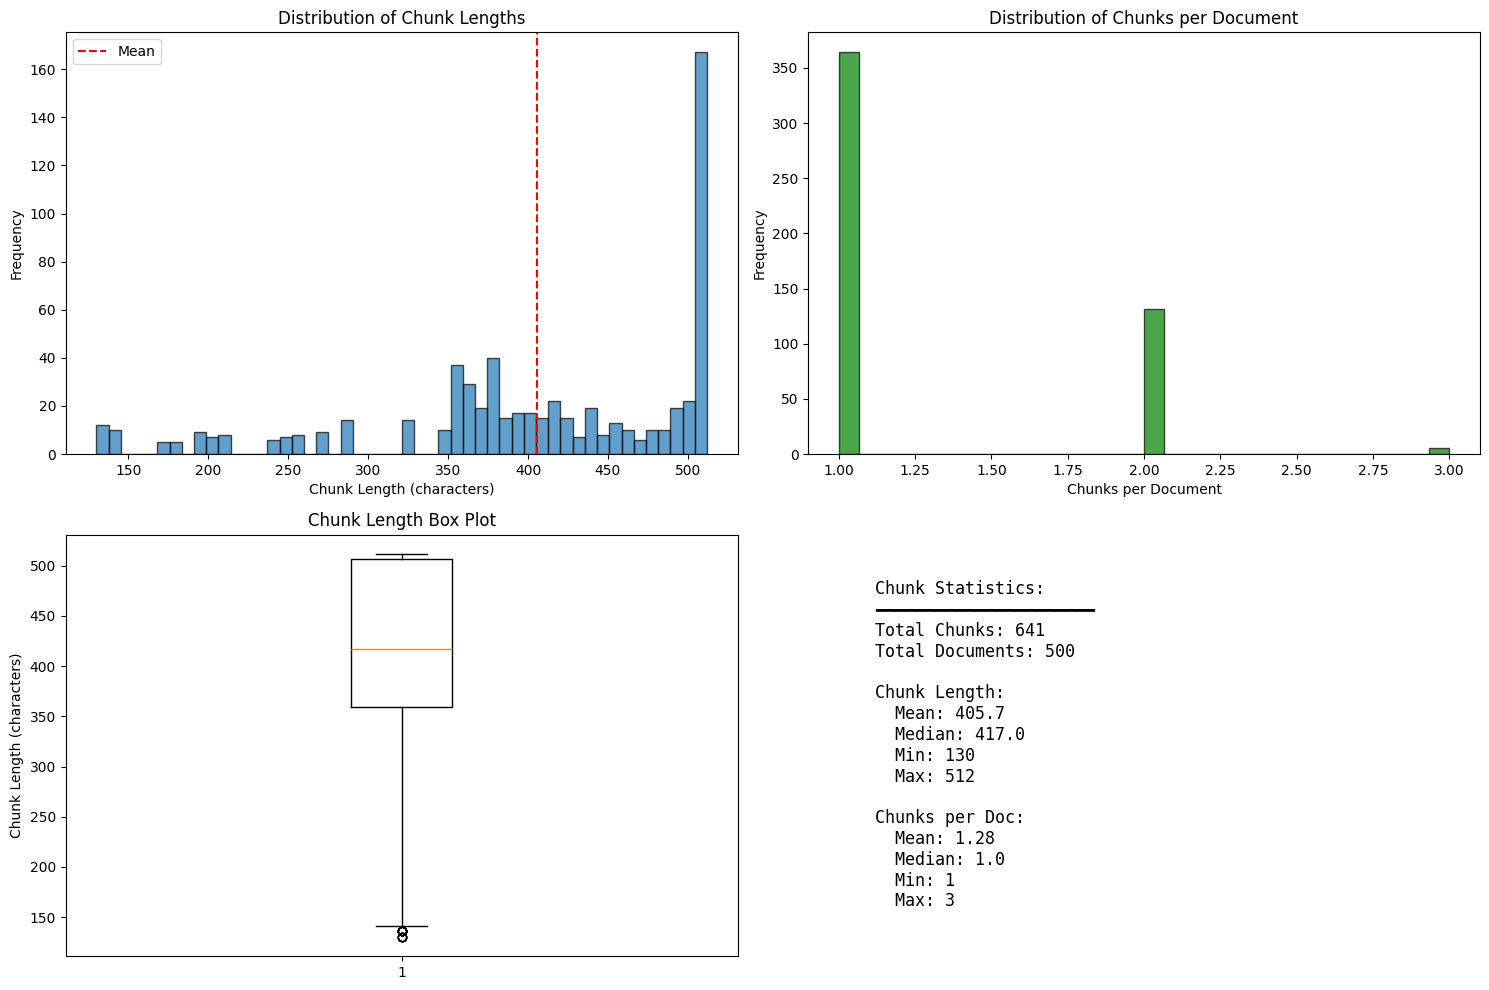

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 청크 길이 분포
chunks_df['text_length'] = chunks_df['text'].apply(len)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 청크 길이 분포
axes[0, 0].hist(chunks_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Chunk Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Chunk Lengths')
axes[0, 0].axvline(chunks_df['text_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# 2. 문서당 청크 수
chunks_per_doc = chunks_df.groupby('doc_id').size()
axes[0, 1].hist(chunks_per_doc, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Chunks per Document')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Chunks per Document')

# 3. 박스플롯
axes[1, 0].boxplot(chunks_df['text_length'])
axes[1, 0].set_ylabel('Chunk Length (characters)')
axes[1, 0].set_title('Chunk Length Box Plot')

# 4. 통계 테이블
stats_text = f"""
Chunk Statistics:
━━━━━━━━━━━━━━━━━━━━━━
Total Chunks: {len(chunks_df):,}
Total Documents: {chunks_df['doc_id'].nunique():,}

Chunk Length:
  Mean: {chunks_df['text_length'].mean():.1f}
  Median: {chunks_df['text_length'].median():.1f}
  Min: {chunks_df['text_length'].min()}
  Max: {chunks_df['text_length'].max()}

Chunks per Doc:
  Mean: {chunks_per_doc.mean():.2f}
  Median: {chunks_per_doc.median():.1f}
  Min: {chunks_per_doc.min()}
  Max: {chunks_per_doc.max()}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'chunk_statistics.png', dpi=150, bbox_inches='tight')
print("\n✅ 통계 그래프 저장: results/chunk_statistics.png")
plt.show()

## 5. 평가용 쿼리셋 생성

In [11]:
# 평가용 질문-답변 쌍 추출
eval_queries = []

# 원본 질문이 있는 청크만 필터링
chunks_with_qa = chunks_df[chunks_df['original_question'].notna()].copy()

# 중복 제거 및 샘플링
unique_questions = chunks_with_qa.drop_duplicates(subset='original_question')

# 평가 쿼리 개수 설정 (config에서 가져오기)
num_eval_queries = min(config['evaluation']['query_count'], len(unique_questions))

# 랜덤 샘플링
np.random.seed(config['evaluation']['random_seed'])
eval_samples = unique_questions.sample(n=num_eval_queries, random_state=config['evaluation']['random_seed'])

for _, row in eval_samples.iterrows():
    eval_queries.append({
        'query_id': row['chunk_id'],
        'question': row['original_question'],
        'ground_truth_answer': row['original_answer'],
        'ground_truth_doc_id': row['doc_id'],
        'ground_truth_chunk_id': row['chunk_id']
    })

# DataFrame으로 변환
eval_queries_df = pd.DataFrame(eval_queries)

print(f"\n✅ 평가 쿼리 생성: {len(eval_queries_df)} queries")
print(f"\n🔍 Sample Query:")
print(eval_queries_df.iloc[0])


✅ 평가 쿼리 생성: 50 queries

🔍 Sample Query:
query_id                            6480979-1-0_chunk_0
question                 외국인특파협회의 회원을 받아들이기 위해 노력한 협회는?
ground_truth_answer                              일본신문협회
ground_truth_doc_id                         6480979-1-0
ground_truth_chunk_id               6480979-1-0_chunk_0
Name: 0, dtype: object


## 6. 데이터 저장

In [12]:
# 청크 데이터 저장 (Parquet)
chunks_file = DATA_DIR / 'corpus_chunks.parquet'
chunks_df.to_parquet(chunks_file, index=False)
print(f"✅ Chunks saved to: {chunks_file}")
print(f"   Size: {chunks_file.stat().st_size / 1024 / 1024:.2f} MB")

# 평가 쿼리 저장 (JSONL)
eval_file = DATA_DIR / 'eval_queries.jsonl'
with open(eval_file, 'w', encoding='utf-8') as f:
    for query in eval_queries:
        f.write(json.dumps(query, ensure_ascii=False) + '\n')
print(f"✅ Eval queries saved to: {eval_file}")

# CSV로도 저장 (검토용)
eval_queries_df.to_csv(DATA_DIR / 'eval_queries.csv', index=False, encoding='utf-8')
print(f"✅ Eval queries CSV saved to: {DATA_DIR / 'eval_queries.csv'}")

print("\n" + "="*60)
print("🎉 Data Ingestion & Chunking Complete!")
print("="*60)
print(f"Total Chunks: {len(chunks_df):,}")
print(f"Total Documents: {chunks_df['doc_id'].nunique():,}")
print(f"Eval Queries: {len(eval_queries_df):,}")
print("="*60)

✅ Chunks saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/datasets/corpus_chunks.parquet
   Size: 0.10 MB
✅ Eval queries saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/datasets/eval_queries.jsonl
✅ Eval queries CSV saved to: /home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/datasets/eval_queries.csv

🎉 Data Ingestion & Chunking Complete!
Total Chunks: 641
Total Documents: 500
Eval Queries: 50



## 무엇을 담나
- 한 샘플의 context를 슬라이딩 윈도우로 자른 여러 chunk
- 각 chunk의 텍스트와 위치 정보(인덱스, 총 개수)
- 원본 문서의 식별자/제목 등 메타데이터
- 원본 질문/정답을 그대로 복사한 값(청크에 맞춰 재생성된 것이 아님)

## DataFrame 컬럼과 의미
- chunk_id: 청크 고유 ID (예: "{doc_id}_chunk_{chunk_index}")
- text: 청크 텍스트(검색/임베딩의 실제 대상)
- language: 언어 코드(ko)
- source: 데이터 출처(예: "KorQuAD 2.0")
- doc_id: 원본 문서 ID(데이터셋의 id)
- title: 원본 문서 제목
- section: 청크 위치 표기(예: "chunk_3_12" → 12개 중 3번째)
- revision_date: 처리 시각(YYYY-MM-DD)
- chunk_index: 청크 인덱스(0부터)
- total_chunks: 해당 문서의 총 청크 수
- original_context_length: 원래 context의 전체 길이(문자 수)
- original_question: 원본 질문(있을 때만, 없으면 빈 문자열)
- original_answer: 원본 정답(있을 때만, 없으면 빈 문자열)
- text_length: 청크 텍스트 길이(후속 통계 셀에서 추가됨)

참고: original_question/answer는 “문서 단위”의 QA를 복사한 값이라, 특정 청크 내부에 반드시 정답 텍스트가 들어있다고 보장하지는 않습니다(공식 KorQuAD 류는 대개 포함되지만, 샘플 데이터일 땐 아닐 수 있음).

## 어디에 저장되나
- 파일: corpus_chunks.parquet
- 노트북에서 만든 `chunks_df`를 그대로 Parquet으로 저장한 것입니다.

원하면 이렇게 다시 확인할 수 있어요(선택):


In [ ]:
import pandas as pd
df = pd.read_parquet("assignment02/datasets/corpus_chunks.parquet")
print(df.shape)
print(df.columns.tolist())
df.head(2)

In [8]:
import pandas as pd
df = pd.read_parquet("/home/dhc99/ajou-llmops-2025-2nd-semester/assignment02/datasets/corpus_chunks.parquet")
print(df.shape)
print(df.columns.tolist())
df.head(100)

(641, 14)
['chunk_id', 'text', 'language', 'source', 'doc_id', 'title', 'section', 'revision_date', 'chunk_index', 'total_chunks', 'original_context_length', 'original_question', 'original_answer', 'text_length']


,chunk_id,text,language,source,doc_id,title,section,revision_date,chunk_index,total_chunks,original_context_length,original_question,original_answer,text_length
0,6566495-0-0_chunk_0,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,ko,KorQuAD 2.0,6566495-0-0,파우스트_서곡,chunk_0_2,2025-10-10,0,2,673,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,교향곡,512
1,6566495-0-0_chunk_1,게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에...,ko,KorQuAD 2.0,6566495-0-0,파우스트_서곡,chunk_1_2,2025-10-10,1,2,673,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,교향곡,289
2,6566495-0-1_chunk_0,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,ko,KorQuAD 2.0,6566495-0-1,파우스트_서곡,chunk_0_2,2025-10-10,0,2,673,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1악장,512
3,6566495-0-1_chunk_1,게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에...,ko,KorQuAD 2.0,6566495-0-1,파우스트_서곡,chunk_1_2,2025-10-10,1,2,673,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1악장,289
4,6566495-0-2_chunk_0,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,ko,KorQuAD 2.0,6566495-0-2,파우스트_서곡,chunk_0_2,2025-10-10,0,2,673,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,베토벤의 교향곡 9번,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6570133-5-1_chunk_1,"4량으로 운전되어 병결 시에는 간쿠 쾌속이 뒷부분, 기슈지 쾌속이 앞부분인 형태로 ...",ko,KorQuAD 2.0,6570133-5-1,한와_선,chunk_1_2,2025-10-10,1,2,594,특별쾌속 윙 호가 사라진 해는?,2008년,210
96,6570134-5-0_chunk_0,간쿠 쾌속 또는 관공쾌속(일본어: 関空快速 칸쿠우카이소쿠)은 간사이 공항 특급 하루...,ko,KorQuAD 2.0,6570134-5-0,한와_선,chunk_0_2,2025-10-10,0,2,594,간쿠 쾌속과 함께 간사이 국제공항 연계 열차인 것은?,간사이 공항 특급 하루카,512
97,6570134-5-0_chunk_1,"4량으로 운전되어 병결 시에는 간쿠 쾌속이 뒷부분, 기슈지 쾌속이 앞부분인 형태로 ...",ko,KorQuAD 2.0,6570134-5-0,한와_선,chunk_1_2,2025-10-10,1,2,594,간쿠 쾌속과 함께 간사이 국제공항 연계 열차인 것은?,간사이 공항 특급 하루카,210
98,6570134-5-1_chunk_0,간쿠 쾌속 또는 관공쾌속(일본어: 関空快速 칸쿠우카이소쿠)은 간사이 공항 특급 하루...,ko,KorQuAD 2.0,6570134-5-1,한와_선,chunk_0_2,2025-10-10,0,2,594,간쿠 쾌속이 덴마 역과 사쿠라노미야 역에 정차하게 된 해는?,2008년,512
